## Fine tuning a pre-trained CNN by modifying the top layers

### Reference Links used for code are as given below. 

1. For data pre-processing and splitting into train, test and validation datasets : https://www.kaggle.com/sagyamthapa/handwritten-math-symbols/code

2. For fine tuning the pre-trained CNN model:
https://deeplizard.com/learn/video/4Tcqw5oIfIg

3. Original code written for fine-tuning, model training and evaluation

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report

/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sneha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
from google.colab import drive
ROOT = '/content/drive'
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
ls

'Getting started.pdf'   image_dataset/


In [5]:
sdir=r'image_dataset'
classlist=os.listdir(sdir)
filepaths=[]
labels=[]
classes=[]
for klass in classlist:    
    classpath=os.path.join(sdir, klass)
    if os.path.isdir(classpath): 
        classes.append(klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            if os.path.isfile(fpath):
                filepaths.append(fpath)
                labels.append(klass)
fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series (labels, name='labels')
df=pd.concat([fseries, Lseries], axis=1)
print (df['labels'].value_counts()) # check balance of dataset - it is reasonably balanced

sub    655
eq     644
dec    624
div    618
add    596
0      595
6      581
mul    577
1      562
8      554
9      547
3      541
4      536
7      533
5      433
2      433
Name: labels, dtype: int64


In [6]:
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state = 123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

In [7]:
def scalar(img):
    return img/127.5-1 # scale pixels between -1 and + 1

gen=ImageDataGenerator(preprocessing_function=scalar)

train_gen=gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col='labels', target_size=(128,128), class_mode='categorical',
                                  color_mode='rgb', shuffle=False)
test_gen=gen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col='labels', target_size=(128,128), class_mode='categorical',
                                  color_mode='rgb', shuffle=False)
valid_gen=gen.flow_from_dataframe(valid_df, x_col= 'filepaths', y_col='labels', target_size=(128,128), class_mode='categorical',
                                  color_mode='rgb', shuffle=False)


Found 8125 validated image filenames belonging to 16 classes.
Found 451 validated image filenames belonging to 16 classes.
Found 452 validated image filenames belonging to 16 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [8]:
base_model=tf.keras.applications.Xception( include_top=False, input_shape=(128,128,3), pooling='max', weights='imagenet') 

x=base_model.output

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x=Dropout(rate=.3, seed=123)(x)                 

output=Dense(len(classes), activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=output)

model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])  


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [10]:
hist = model.fit(x=train_gen, epochs=12, verbose=1, validation_data=valid_gen)



Epoch 1/12
254/254 [==============================] - 1598s 6s/step - loss: 0.5435 - accuracy: 0.8441 - val_loss: 0.0148 - val_accuracy: 0.9978
Epoch 2/12
254/254 [==============================] - 51s 200ms/step - loss: 0.0178 - accuracy: 0.9932 - val_loss: 0.0105 - val_accuracy: 0.9978
Epoch 3/12
254/254 [==============================] - 50s 197ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.0209 - val_accuracy: 0.9867
Epoch 4/12
254/254 [==============================] - 51s 199ms/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.0071 - val_accuracy: 0.9956
Epoch 5/12
254/254 [==============================] - 50s 198ms/step - loss: 0.0056 - accuracy: 0.9994 - val_loss: 5.8056e-04 - val_accuracy: 1.0000
Epoch 6/12
254/254 [==============================] - 50s 198ms/step - loss: 6.5281e-04 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/12
254/254 [==============================] - 51s 199ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0020 -

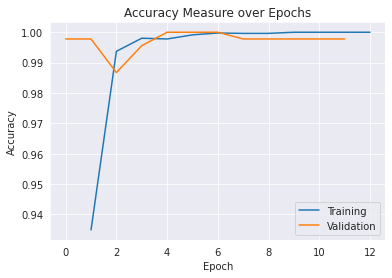

In [11]:
epochs = [i for i in range(1,13)]
plt.plot(epochs, hist.history['accuracy'], hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy Measure over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

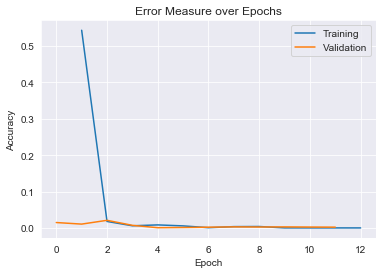

In [4]:
loss = ([0.5435,0.0178,0.0059,0.0083,0.0056,6.5281e-04,0.0036,0.0039,8.5104e-05,3.6823e-05,2.6684e-05,1.2869e-05])
val_loss = ([0.0148,0.0105,0.0209,0.0071,5.8056e-04,0.0012,0.0020,0.0029,0.0025,0.0028,0.0024,0.0021])

epochs = [i for i in range(1,13)]
plt.plot(epochs, loss, val_loss)
plt.legend(['Training', 'Validation'])
plt.title('Error Measure over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

15/15 [==============================] - 85s 6s/step - loss: 4.0112e-05 - accuracy: 1.0000
Model Accuracy on Test Set:  100.0


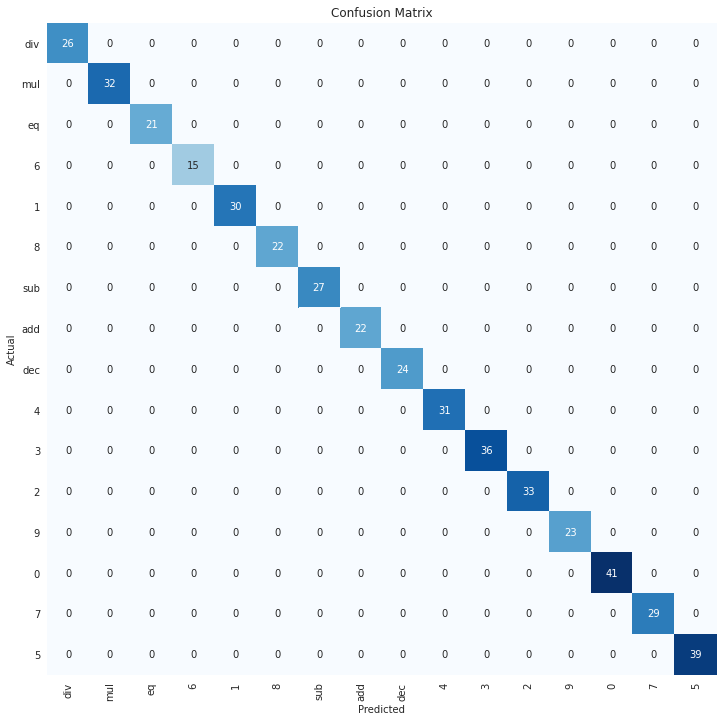

Classification Report:
----------------------
               precision    recall  f1-score   support

         div       1.00      1.00      1.00        26
         mul       1.00      1.00      1.00        32
          eq       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        22
         sub       1.00      1.00      1.00        27
         add       1.00      1.00      1.00        22
         dec       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        36
           2       1.00      1.00      1.00        33
           9       1.00      1.00      1.00        23
           0       1.00      1.00      1.00        41
           7       1.00      1.00      1.00        29
           5       1.00      1.00      1.00        39

    accuracy                     

In [12]:
acc=model.evaluate(test_gen, verbose=1)[1]*100
print ('Model Accuracy on Test Set: ', acc)
preds=model.predict(test_gen)
y_pred=[]
y_true=[]
for i, p in enumerate(preds):
    y_pred.append(np.argmax(p))
    y_true.append(test_gen.labels[i])
y_pred=np.array(y_pred)
y_true=np.array(y_true)
cm = confusion_matrix(y_true, y_pred )
clr = classification_report(y_true, y_pred, target_names=classes)
length=len(classes)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()    
print("Classification Report:\n----------------------\n", clr)
